In [1]:
# ---------------------------------
# Cell 1: Install, Import, and Authenticate
# ---------------------------------
import sys
sys.path.append('.') # Assumes notebook and burn_classifier folder are at the same level
import burn_classifier as bc
import os
import json
import ee
from IPython.display import display, HTML 

In [2]:
# Authenticate GEE and Mount Google Drive
WORK_DIR = bc.auth_and_init()

GEE authentication required...



Successfully saved authorization token.
Working directory set to: /content/drive/MyDrive/GEE_exports


In [3]:
# ---------------------------------
# Cell 2: Define Parameters (User Input)
# ---------------------------------

# User inputs for location and dates
location_name = 'Malibu, California'
aoi_name = location_name.split(',')[0].replace(' ', '_') # Creates a name like 'Malibu' for filenames
aoi = ee.Geometry.Rectangle([-118.75, 34.00, -118.50, 34.10])

# Pre-fire dates (e.g., for Woolsey Fire: 2018-06-01 to 2018-08-31)
pre_start = "2018-06-01"
pre_end   = "2018-08-31"

# Post-fire dates (e.g., for Woolsey Fire: 2019-01-01 to 2019-04-30)
post_start = "2019-01-01"
post_end   = "2019-04-30"

Displaying map for: Malibu, California...


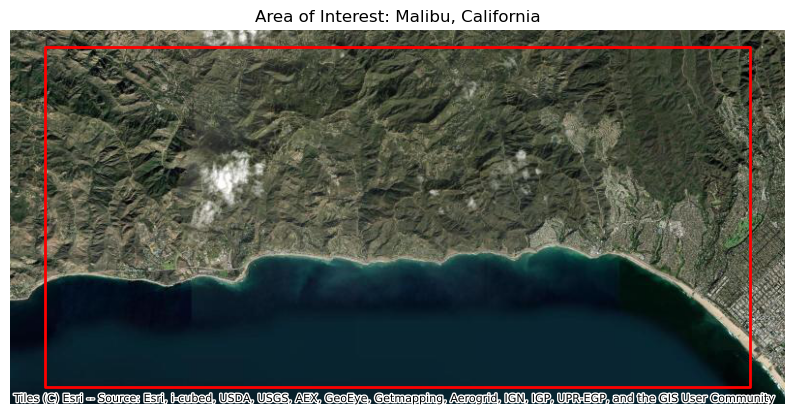

<Axes: title={'center': 'Area of Interest: Malibu, California'}>

In [5]:
# ---------------------------------
# Cell 3: Get AOI and Plot Bounding Box
# ---------------------------------
# Call gee_interface module
bc.display_aoi_map(aoi, location_name=location_name, zoom_level=12)

In [6]:
# ---------------------------------
# Cell 4: Download NBR Imagery from GEE
# ---------------------------------
print("\nStep 1: Downloading data from GEE")
# Call gee_interface module
pre_tif_name, post_tif_name = bc.fetch_nbr_images(
    aoi, (pre_start, pre_end), (post_start, post_end), 
    folder=os.path.basename(WORK_DIR), 
    aoi_name=aoi_name
)

print("\n!!! IMPORTANT !!!")
print("Please go to Google Drive or the GEE Code Editor 'Tasks' tab.")
print(f"Wait for {pre_tif_name} and {post_tif_name} to finish exporting, then run the next cell.")


Step 1: Downloading data from GEE
Starting GEE task: Malibu_pre_nbr...
Starting GEE task: Malibu_post_nbr...

---
Tasks started. Please check the GEE 'Tasks' tab and proceed after completion.
Files will be exported to your Google Drive 'GEE_exports' folder.

!!! IMPORTANT !!!
Please go to Google Drive or the GEE Code Editor 'Tasks' tab.
Wait for Malibu_pre_nbr.tif and Malibu_post_nbr.tif to finish exporting, then run the next cell.


In [7]:
display(HTML('''
<div style="border-radius: 5px; padding: 10px; background-color: #fce5cd; color: #b45f06;">
<b>WARNING:</b>
Download the file from the cloud to the local device.
</div>
'''))

In [8]:
# ---------------------------------
# Cell 5: Local Analysis with Rasterio
# ---------------------------------
WORK_DIR="."
pre_tif_path = os.path.join(WORK_DIR, pre_tif_name)
post_tif_path = os.path.join(WORK_DIR, post_tif_name)
dnbr_tif_path = os.path.join(WORK_DIR, f"{aoi_name}_dnbr_local.tif")
classified_tif_path = os.path.join(WORK_DIR, f"{aoi_name}_classified_local.tif")

if os.path.exists(pre_tif_path) and os.path.exists(post_tif_path):
    print("\nStep 2: Files found. Processing locally (using Rasterio)...")
    
    # Calculate dNBR (calls local_analysis)
    bc.calculate_dnbr(pre_tif_path, post_tif_path, dnbr_tif_path)
    
    # Classify (calls local_analysis)
    bc.classify_severity(dnbr_tif_path, classified_tif_path)
    
    print("Local processing complete.")
else:
    print(f"\nError: Input TIF files not found in {WORK_DIR}.")
    print("Please ensure GEE tasks completed and the files are synced/downloaded.")


Step 2: Files found. Processing locally (using Rasterio)...
dNBR image saved to: .\Malibu_dnbr_local.tif
Classified image saved to: .\Malibu_classified_local.tif
Local processing complete.



Step 3: Generating local visualization map...


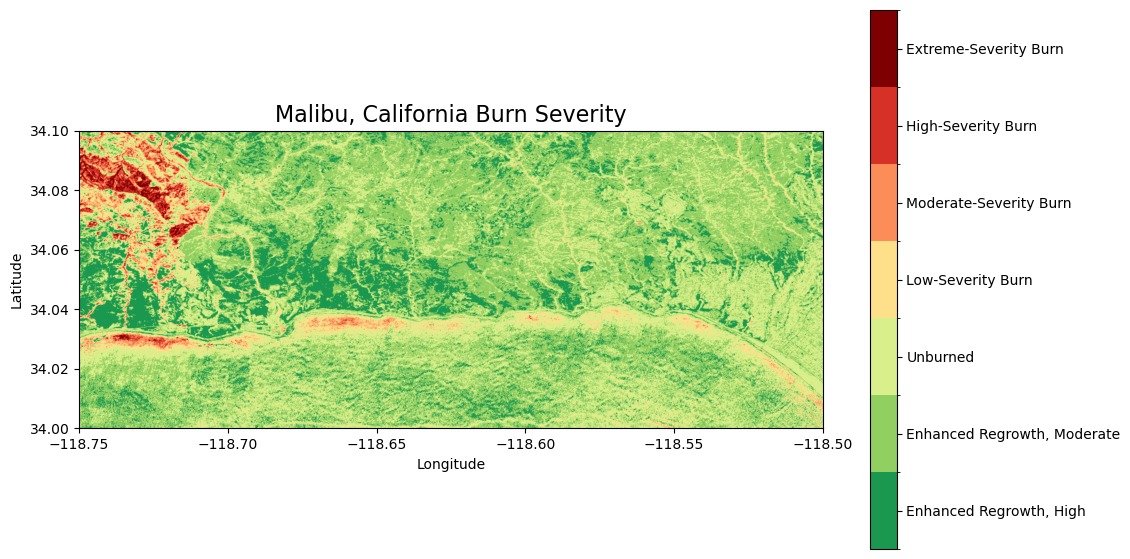


Step 4: Calculating areas locally...
Area calculation complete.
--- Malibu, California Area Report (Hectares) ---
{
    "Enhanced Regrowth, High": {
        "class_id": 1,
        "area_hectares": 4956.55
    },
    "Enhanced Regrowth, Moderate": {
        "class_id": 2,
        "area_hectares": 14735.56
    },
    "Unburned": {
        "class_id": 3,
        "area_hectares": 10556.07
    },
    "Low-Severity Burn": {
        "class_id": 4,
        "area_hectares": 1581.04
    },
    "Moderate-Severity Burn": {
        "class_id": 5,
        "area_hectares": 646.94
    },
    "High-Severity Burn": {
        "class_id": 7,
        "area_hectares": 136.91
    },
    "Total_Analyzed_Area": {
        "area_hectares": 33001.16
    }
}
---------------------------------


In [9]:
# ---------------------------------
# Cell 6: Local Visualization & Area Calculation
# ---------------------------------
if os.path.exists(classified_tif_path):
    # 9. Visualize
    print("\nStep 3: Generating local visualization map...")
    bc.plot_classified_map(classified_tif_path, title=f"{location_name} Burn Severity")
    
    # 10. Calculate Area (calls local_analysis)
    print("\nStep 4: Calculating areas locally...")
    area_report = bc.calculate_area(classified_tif_path)
    
    print(f"--- {location_name} Area Report (Hectares) ---")
    print(json.dumps(area_report, indent=4, ensure_ascii=False))
    print("---------------------------------")
else:
    print("Classified file not generated, skipping steps 3 and 4.")

In [10]:
area_report = bc.calculate_area(classified_tif_path)

Area calculation complete.


In [11]:
print(json.dumps(area_report, indent=4, ensure_ascii=False))

{
    "Enhanced Regrowth, High": {
        "class_id": 1,
        "area_hectares": 4956.55
    },
    "Enhanced Regrowth, Moderate": {
        "class_id": 2,
        "area_hectares": 14735.56
    },
    "Unburned": {
        "class_id": 3,
        "area_hectares": 10556.07
    },
    "Low-Severity Burn": {
        "class_id": 4,
        "area_hectares": 1581.04
    },
    "Moderate-Severity Burn": {
        "class_id": 5,
        "area_hectares": 646.94
    },
    "High-Severity Burn": {
        "class_id": 7,
        "area_hectares": 136.91
    },
    "Total_Analyzed_Area": {
        "area_hectares": 33001.16
    }
}
